In [76]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from glob import glob
import pandas as pd
from datetime import datetime, time

In [78]:
from data.subjects_to_keep import subjects_to_keep as users
from data.data_path import data_path

from plot import plot

In [79]:
u =  users[0] #"11KD" #"09AU"  "11KD"
file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]
#     print(f"Found the file `{file}`")

df = pd.read_csv(file, index_col=0)
df.dt = pd.to_datetime(df.dt, utc=False, format='ISO8601')
df.dt = df.dt.dt.tz_convert('Europe/London')

In [80]:
df.head(1)

,user,id,dt,dt_last_boot,step_last_boot,step_midnight
0,02MY,59488,2023-06-26 15:20:13.635000+01:00,2023-06-26 06:19:41.489000+0000,404,0


In [81]:
min_date = df.dt.min().date()
days = np.asarray([(dt.date() - min_date).days for dt in df.dt])

In [82]:
all_timestep = (np.asarray([(dt - datetime.combine(dt, time.min, dt.tz)).total_seconds() 
                       for dt in df.dt]) 
            / 86400)

In [83]:
np.min(all_timestep), np.max(all_timestep)

(0.04578157407407407, 0.9863385995370371)

In [84]:
all_pos = df.step_midnight.values

In [127]:
position = np.linspace(0, 7000, 10)
velocity = np.linspace(-50000, 5000, 10)

In [128]:
uniq_days = np.unique(days)

In [129]:
timestep_new = np.linspace(0, 1, 10)
dt = timestep_new[1] - timestep_new[0]

In [130]:
n_timestep = timestep_new.size
n_position = position.size
n_velocity = velocity.size

In [131]:
alpha_tpvv = np.zeros((n_timestep, n_position, n_velocity, n_velocity))

In [132]:
for day in uniq_days:
    is_day = days == day
    timestep, pos = all_timestep[is_day], all_pos[is_day]
    f = interpolate.interp1d(timestep, pos, kind="linear")

    pos_new = np.zeros_like(timestep_new)
    can_be_interpolated = (timestep_new >= timestep.min()) * (timestep_new <= timestep.max())
    pos_new[can_be_interpolated] = f(timestep_new[can_be_interpolated])
    pos_new[timestep_new < timestep.min()] = 0
    pos_new[timestep_new > timestep.max()] = pos.max()
    
    # Compute the diff
    y_diff = np.diff(pos_new) / dt
    x_diff = pos_new[:-1]  # Forward approximation
    
    print(f"{y_diff.min():.1f}, {y_diff.max():.1f}")

    # Discretize ------------------
    
    bins = list(velocity) + [np.inf]
    v_indexes = np.digitize(y_diff, bins, right=False) - 1
    # print(f"len bins {len(bins)} min v idx {min(v_indexes)}, max v idx {max(v_indexes)}")
    
    bins = list(position) + [np.inf]
    p_indexes = np.digitize(pos_new, bins, right=False) - 1
    
    n = len(v_indexes) - 1
    
    # density = hist / np.sum(hist)
    for i in range(n):
        p = p_indexes[i]
        v = v_indexes[i]
        v_prime = v_indexes[i + 1]
        alpha_tpvv[i, p, v, v_prime] += 1


0.0, 42062.4
0.0, 51489.3
0.0, 53778.3
0.0, 68587.8
0.0, 44034.8
0.0, 68305.8
769.8, 34660.1
8.7, 56017.0
0.0, 42932.5
0.0, 61324.0
0.0, 54498.0
0.0, 44526.8
0.0, 55947.0
0.0, 61442.0
0.0, 29163.0
0.0, 66996.0
0.0, 83272.1
0.0, 76381.2
0.0, 66861.0


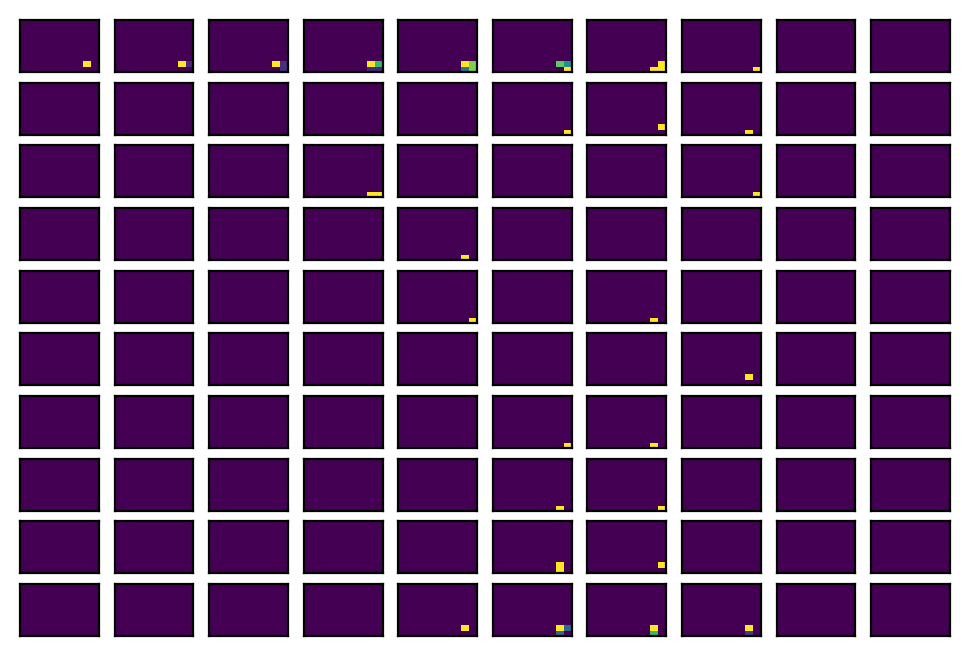

In [133]:
fig, axes = plt.subplots(
                nrows=n_position,
                ncols=n_timestep,
                figsize=(6, 4))
for t_idx in range(n_timestep):
    for p_idx in range(n_position):
        ax = axes[p_idx, t_idx]
        img = alpha_tpvv[t_idx, p_idx, :, :]
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
plt.show()